https://www.kaggle.com/c/mlcourse-dota2-win-prediction/overview

In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os

import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import time
from tqdm import tqdm_notebook
#from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, 
import statsmodels.api as sm
import warnings
#warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier


In [2]:
import ujson as json

In [3]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [4]:
PATH_TO_DATA = 'data/'

Training function

In [5]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    # placeholder for out-of-fold, i.e. validation scores
    oof = np.zeros(len(X)) 
    prediction = np.zeros(len(X_test))
    #for predictions
    scores = []
    # and for feature importance
    feature_importance = pd.DataFrame()
    
    #RUN THE LOOP OVER FOLDS
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        #print(train_index, valid_index)
        print(f"train len is: {len(train_index)};\nvalid len is: {len(valid_index)}")
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        #X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            
            #TRAIN THE MODEL
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 500)
            
            y_pred_valid = model.predict(X_valid)
            
            #CALCULATE PREDICTIONS FOR TEST DATA, using best_iteration on the fold
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. AUC: {score:.4f}.') #
            print('') #
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
        
        #CALCULATE PREDICTION FOR VALIDATION SET
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
            
    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [6]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': 20,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'bagging_seed' : 42,
          'objective': 'binary'
         }

In [7]:
# https://www.kaggle.com/shokhan/lightgbm-starter-code - CELL 14
params2 = {
        'boost': 'gbdt',
    
        'bagging_freq': 5,  #handling overfitting
        'bagging_fraction': 0.5,  #handling overfitting - adding some noise
        'boost_from_average':'false',
        'feature_fraction': 0.05, #handling overfitting
        'learning_rate': 0.01,  #the changes between one auc and a better one gets really small thus a small learning rate performs better
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 10,
        'num_threads': 5,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }

### JSON_DATA
I'll use functions from this kernel: https://www.kaggle.com/kashnitsky/dota-2-win-prediction-random-forest-starter

In [8]:
with open(os.path.join('data/', 'train_matches.jsonl')) as fin:
    # read the 18-th line
    for i in range(18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

The match object is now a big Python dictionary. In **match['players']** we have a description of each player.

In [9]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [10]:
player = match['players'][1]
print(len(player['times']))

40


In [11]:
player.keys()

dict_keys(['player_slot', 'hero_id', 'hero_name', 'account_id_hash', 'ability_upgrades', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'stuns', 'max_hero_hit', 'times', 'gold_t', 'lh_t', 'dn_t', 'xp_t', 'obs_log', 'sen_log', 'obs_left_log', 'sen_left_log', 'purchase_log', 'kills_log', 'buyback_log', 'runes_log', 'obs', 'sen', 'actions', 'pings', 'purchase', 'gold_reasons', 'xp_reasons', 'killed', 'item_uses', 'ability_uses', 'hero_hits', 'damage', 'damage_taken', 'damage_inflictor', 'runes', 'killed_by', 'kill_streaks', 'multi_kills', 'life_state', 'healing', 'damage_inflictor_received', 'randomed', 'pred_vict', 'gold', 'lh', 'xp', 'x', 'y', 'hero_inventory', 'hero_stash', 'health', 'max_health', 'max_mana', 'level', 'kills', 'deaths', 'assists', 'denies', 'nearby_creep_death_count'])

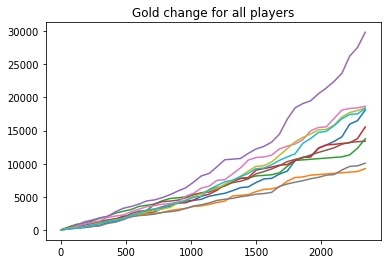

In [12]:
for player in match['players']:
    plt.plot(player['times'], player['gold_t'])
    
plt.title('Gold change for all players');

In [13]:
json_list = [] #store data that are read
number_of_rows = 50 #how many lines to read 

#reading data from .jsonl file
with open(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')) as fin:
    for i in range(number_of_rows):
        line = fin.readline()
        json_list.append(json.loads(line))
        
#how many matches to read. For example I took 1
for i in range(1, 2):
    for j in range(1, 2):#there is 5 players in each team. But I want to look on only one player.
        print(json.dumps(json_list[i]['players'][j], indent=4, sort_keys=True))

{
    "ability_upgrades":[
        {
            "ability":5514,
            "level":1,
            "time":232
        },
        {
            "ability":5515,
            "level":2,
            "time":304
        },
        {
            "ability":5515,
            "level":3,
            "time":322
        },
        {
            "ability":5514,
            "level":4,
            "time":391
        },
        {
            "ability":5515,
            "level":5,
            "time":499
        },
        {
            "ability":5517,
            "level":6,
            "time":581
        }
    ],
    "ability_uses":{
        "centaur_double_edge":11,
        "centaur_hoof_stomp":8,
        "centaur_stampede":2
    },
    "account_id_hash":"1c2500195e6ab646fc9371344724aa77",
    "actions":{
        "1":3679,
        "10":183,
        "11":8,
        "15":19,
        "16":18,
        "19":14,
        "2":2,
        "33":183,
        "4":810,
        "5":4,
        "6":42,
        "7":12,


}


In [14]:
for i in range(1, 5): #now we will look at 4 matches
    for j in range(1, 5):#and now will take 5 players
        print(json.dumps(list(map(lambda x: x['id'][5:],
                                  json_list[i]['players'][j]['hero_inventory'])),
                         indent=4, sort_keys=True))

[
    "stout_shield",
    "soul_ring",
    "tranquil_boots",
    "chainmail"
]
[
    "magic_wand",
    "dust",
    "boots",
    "ward_dispenser",
    "tpscroll"
]
[
    "magic_wand",
    "pers",
    "blight_stone",
    "tpscroll",
    "ring_of_aquila"
]
[
    "boots",
    "stout_shield",
    "tpscroll"
]
[
    "tango",
    "flask",
    "stout_shield",
    "clarity",
    "enchanted_mango",
    "tpscroll"
]
[
    "stout_shield",
    "blight_stone",
    "tpscroll"
]
[
    "stout_shield",
    "quelling_blade",
    "tango",
    "tpscroll"
]
[
    "tango",
    "faerie_fire",
    "tpscroll"
]
[
    "soul_ring",
    "stout_shield",
    "magic_wand",
    "boots",
    "faerie_fire",
    "tpscroll"
]
[
    "boots",
    "bottle",
    "null_talisman",
    "helm_of_iron_will",
    "null_talisman"
]
[
    "tranquil_boots",
    "magic_stick",
    "orb_of_venom",
    "ward_observer"
]
[
    "power_treads",
    "quelling_blade",
    "clarity",
    "ring_of_health",
    "tpscroll"
]
[
    "ring_of_basili

## players

#### Function to read files with game descriptions
The following function read_matches(filename), can be used to read raw data on Dota 2 games.

We recommend to install two Python packages: ujson and tqdm, it'll make the execution faster and

In [15]:
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    print(filename)
    total_matches = MATCHES_COUNT.get(filename)
    print(total_matches)
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

#### How to build initial features from scratch
Now we diclose the code that we used to build initial features train_features.csv and test_features.csv. You can modify the following code to add more features.

In a nutshell:

1. ***extract_features_csv(match)*** extracts features from game descriptions and writes them into a dictionary
2. ***extract_targets_csv(match, targets)*** extracts the target variable radiant_win
3. iterating through the file with raw data, we collect all features
4. with ***pandas.DataFrame.from_records()*** we create dataframes with new features

In [16]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    #('lobby_type', lambda m: m['lobby_type']), # ну уж вряд ли
    ('objectives_len', lambda m: len(m['objectives'])), # То же хз нужно ли
    #('chat_len', lambda m: len(m['chat'])),# ну уж вряд ли
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    #'x', #### координаты на карте? хех
    #'y', #### ?
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

#### Достаем признаки для обучения

In [17]:
def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
            
        row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
        row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
        row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
        row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
        row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
        row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))
        # добавляем айтемы https://www.kaggle.com/grazder/hero-items-guide
        row.append((f'{player_name}_items', list(map(lambda x: x['id'][5:], player['hero_inventory']))))
            
    return collections.OrderedDict(row)

#### Достаем признаки для ответа

In [18]:
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

### Составляем новые матрицы для обучения, теста и ответа

In [19]:
def create_features_from_jsonl(matches_file):
  
    df_new_features = []

    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']
        features = extract_features_csv(match)

        df_new_features.append(features)

    df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
    return df_new_features

#### ВСЕ СОХРАНЕНО И ДАННЫЕ УЖЕ НАХОДЯТСЯ В ОГУРЧИКАХ!!!!!!!!!!!!!!

```python
%%time
train_new_features = create_features_from_jsonl(os.path.join(PATH_TO_DATA, 'train_matches.jsonl'))
```

```python
test_new_features = create_features_from_jsonl(os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))
```

```python
%%time
PATH_TO_DATA = 'data/'
train_new_features = []
train_new_targets = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    
    match_id_hash = match['match_id_hash']
    #features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    #train_new_features.append(features)
    train_new_targets.append(targets)
print(train_new_targets[:5])

train_new_targets = pd.DataFrame.from_records(train_new_targets).set_index('match_id_hash')
```

#### Сохраняем маринованные огурчики

```python
import pickle as pkl

#Better to save extracted data in files, because extracting takes time...
train_new_features.to_pickle('data/df_train.pkl')
train_new_targets.to_pickle('data/df_target.pkl')
test_new_features.to_pickle('data/df_test.pkl')
```

#### Айтемы ---

In [20]:
def add_items_dummies(train_df, test_df):
    
    full_df = pd.concat([train_df, test_df], sort=False)
    train_size = train_df.shape[0]

    for team in 'r', 'd':
        players = [f'{team}{i}' for i in range(1, 6)]
        item_columns = [f'{player}_items' for player in players]

        d = pd.get_dummies(full_df[item_columns[0]].apply(pd.Series).stack()).sum(level=0, axis=0)
        dindexes = d.index.values

        for c in item_columns[1:]:
            d = d.add(pd.get_dummies(full_df[c].apply(pd.Series).stack()).sum(level=0, axis=0), fill_value=0)
            d = d.loc[dindexes]

        full_df = pd.concat([full_df, d.add_prefix(f'{team}_item_')], axis=1, sort=False)
        full_df.drop(columns=item_columns, inplace=True)

    train_df = full_df.iloc[:train_size, :]
    test_df = full_df.iloc[train_size:, :]

    return train_df, test_df

In [21]:
def drop_consumble_items(train_df, test_df):
    
    full_df = pd.concat([train_df, test_df], sort=False)
    train_size = train_df.shape[0]

    for team in 'r', 'd':
        consumble_columns = ['tango', 'tpscroll', 
                             'bottle', 'flask',
                            'enchanted_mango', 'clarity',
                            'faerie_fire', 'ward_observer',
                            'ward_sentry']
        
        starts_with = f'{team}_item_'
        consumble_columns = [starts_with + column for column in consumble_columns]
        full_df.drop(columns=consumble_columns, inplace=True)

    train_df = full_df.iloc[:train_size, :]
    test_df = full_df.iloc[train_size:, :]

    return train_df, test_df

# ЗАГРУЖАЕМ ДАННЫЕ ИЗ ТРЕХЛИТРОВЫХ БАНОК

In [22]:
%%time
train = pd.read_pickle('data/df_train.pkl')
target = pd.read_pickle('data/df_target.pkl')
test = pd.read_pickle('data/df_test.pkl')

Wall time: 2.28 s


# Y

In [77]:
y = target['radiant_win']

In [23]:
train.head()

,game_time,game_mode,objectives_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r1_ability_level,r1_max_hero_hit,r1_purchase_count,r1_count_ability_use,r1_damage_dealt,r1_damage_received,r1_items,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r2_ability_level,r2_max_hero_hit,r2_purchase_count,r2_count_ability_use,r2_damage_dealt,r2_damage_received,r2_items,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r3_ability_level,r3_max_hero_hit,r3_purchase_count,r3_count_ability_use,r3_damage_dealt,r3_damage_received,r3_items,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r4_ability_level,r4_max_hero_hit,r4_purchase_count,r4_count_ability_use,r4_damage_dealt,r4_damage_received,r4_items,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,r5_ability_level,r5_max_hero_hit,r5_purchase_count,r5_count_ability_use,r5_damage_dealt,r5_damage_received,r5_items,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d1_ability_level,d1_max_hero_hit,d1_purchase_count,d1_count_ability_use,d1_damage_dealt,d1_damage_received,d1_items,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d2_ability_level,d2_max_hero_hit,d2_purchase_count,d2_count_ability_use,d2_damage_dealt,d2_damage_received,d2_items,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d3_ability_level,d3_max_hero_hit,d3_purchase_count,d3_count_ability_use,d3_damage_dealt,d3_damage_received,d3_items,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d4_ability_level,d4_max_hero_hit,d4_purchase_count,d4_count_ability_use,d4_damage_dealt,d4_damage_received,d4_items,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d5_ability_level,d5_max_hero_hit,d5_purc

In [24]:
train.shape, target.shape, test.shape

((39675, 293), (39675, 5), (10000, 293))

In [25]:
%%time
train, test = add_items_dummies(train, test)
train, test = drop_consumble_items(train,test)
train.shape, test.shape

Wall time: 2min 39s


### OOOOOOF

In [112]:
def DataFrameWithNewFeatures(df):
    
    df_copy = df.copy()
    # time in minutes
    df_copy['game_time_min'] = np.round(df_copy.game_time // 60,3)
    
    for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp',
              'health', 'max_health', 'max_mana', 'level', 'stuns',
              'creeps_stacked', 'camps_stacked', 'rune_pickups',
              'firstblood_claimed', 'teamfight_participation',
              'towers_killed','roshans_killed', 'obs_placed',
              'sen_placed', 'ability_level','max_hero_hit', 'purchase_count',
              'count_ability_use', 'damage_dealt', 'damage_received']:
        
        r_columns = [f'r{i}_{c}' for i in range(1, 6)]
        d_columns = [f'd{i}_{c}' for i in range(1, 6)]

        df_copy['r_total_' + c] = df_copy[r_columns].sum(axis = 1)
        df_copy['d_total_' + c] = df_copy[d_columns].sum(axis = 1)
        df_copy['total_' + c + '_ratio'] = df_copy['r_total_' + c] / df_copy['d_total_' + c]

        df_copy['r_std_' + c] = df_copy[r_columns].std(axis = 1)
        df_copy['d_std_' + c] = df_copy[d_columns].std(axis = 1)
        df_copy['std_' + c + '_ratio'] = df_copy['r_std_' + c] / df_copy['d_std_' + c]

        df_copy['r_mean_' + c] = df_copy[r_columns].mean(axis = 1)
        df_copy['d_mean_' + c] = df_copy[d_columns].mean(axis = 1)
        df_copy['mean_' + c + '_ratio'] = df_copy['r_mean_' + c] / df_copy['d_mean_' + c]
        
        # "поминутные фичи"
        features_per_minute = ['gold', 'xp','kills','assists', 'lh', 'deaths', 'damage_dealt']
        
        if c in features_per_minute:
            init_col_names = [f'{team}{i}_{name}' for team in ['r','d'] for i in range(1, 6) 
                         for name in ['gold', 'xp','kills','assists', 'lh', 'deaths', 'damage_dealt']]
            output_names = [f'{team}{i}_{name}' for team in ['r','d'] for i in range(1, 6) 
                            for name in ['g', 'x', 'k', 'a', 'lh', 'death','d']]

            for new_col_name in output_names:
                for init_col in init_col_names:
                    df_copy[new_col_name + 'pm'] = df_copy[init_col] / df_copy['game_time_min']
    
    # HERO KDA PER MINUTE
    for x, y, z in zip([f'{team}{i}_kpm' for team in ['r','d'] for i in range(1,6)],
                       [f'{team}{i}_apm'for  team in ['r','d'] for i in range(1,6)],
                       [f'{team}{i}_deaths'for  team in ['r','d'] for i in range(1,6)]):
        
        for j in [f'{team}{i}_kdapm' for team in ['r','d'] for i in range(1,6)]:
            df_copy[j] = (df_copy[x] + df_copy[y])/df_copy[z] / df_copy['game_time_min']
            
    
    # скорее всего когда бесконечность заменяем 0 это должно как-то отрицательно влиять - хезе
    # бесконечности вылезают в строках 18 --- 28
    df_copy.fillna(value = 0, inplace =True)
    df_copy.replace(to_replace=[np.inf, -np.inf], value = 0, inplace = True)
    
    df_copy.index.name = 'match_id_hash'
    
    return df_copy

In [51]:
%%time
train_new = DataFrameWithNewFeatures(train)
test_new = DataFrameWithNewFeatures(test)

Wall time: 1min 5s


#### shape check

In [52]:
train_new.shape, train.shape, test_new.shape

((39675, 991), (39675, 667), (10000, 991))

In [53]:
train_new.head()

,game_time,game_mode,objectives_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r1_ability_level,r1_max_hero_hit,r1_purchase_count,r1_count_ability_use,r1_damage_dealt,r1_damage_received,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r2_ability_level,r2_max_hero_hit,r2_purchase_count,r2_count_ability_use,r2_damage_dealt,r2_damage_received,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r3_ability_level,r3_max_hero_hit,r3_purchase_count,r3_count_ability_use,r3_damage_dealt,r3_damage_received,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r4_ability_level,r4_max_hero_hit,r4_purchase_count,r4_count_ability_use,r4_damage_dealt,r4_damage_received,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,r5_ability_level,r5_max_hero_hit,r5_purchase_count,r5_count_ability_use,r5_damage_dealt,r5_damage_received,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d1_ability_level,d1_max_hero_hit,d1_purchase_count,d1_count_ability_use,d1_damage_dealt,d1_damage_received,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d2_ability_level,d2_max_hero_hit,d2_purchase_count,d2_count_ability_use,d2_damage_dealt,d2_damage_received,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d3_ability_level,d3_max_hero_hit,d3_purchase_count,d3_count_ability_use,d3_damage_dealt,d3_damage_received,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d4_ability_level,d4_max_hero_hit,d4_purchase_count,d4_count_ability_use,d4_damage_dealt,d4_damage_received,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d5_ability_level,d5_max_hero_hit,d5_purchase_count,d5_count_ability_use,d5_damage_dealt,d5_damage_received,r_item_abyssal

## Heroes-to-sparse

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

This is the function to make one_hot_encoding for heroes in whole team

In [55]:
def hero_dummies(X_train, X_test, let):
    r_cols = [let +'%s_hero_id' %i for i in range(1, 6)]
    
    X = pd.concat([X_train, X_test])
    X['herois'+ let] = X.apply(lambda row: ' '.join(row.loc[r_cols].map(int).map(str)), axis=1)
    
    cvv = CountVectorizer()
    heroes = pd.DataFrame(cvv.fit_transform(X['herois'+let]).todense(), columns=cvv.get_feature_names(), index=X.index)
    
    return heroes.loc[X_train.index], heroes.loc[X_test.index]

In [56]:
%%time
train_r, test_r = hero_dummies(train_new, test_new, 'r')
train_d, test_d = hero_dummies(train_new, test_new, 'd')

Wall time: 1min 39s


In [66]:
type(train_r['10'])

pandas.core.series.Series

# WR

In [93]:
print(train_r['10'].value_counts(), '\n')
print((train_r['10'] + train_d['10']).value_counts())

0    37790
1     1885
Name: 10, dtype: int64 

0    35780
1     3895
Name: 10, dtype: int64


In [91]:
hero_total_picks_train = pd.concat([(train_r + train_d), y], axis = 1)
hero_total_picks_test = pd.concat([(test_r + test_d), y], axis = 1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


### Uniting 2

In [94]:
%%time
train_1000 = train_new.join(train_r, rsuffix='_r').join(train_d, rsuffix='_d')
test_1000 = test_new.join(test_r, rsuffix='_r').join(test_d, rsuffix='_d')

Wall time: 523 ms


In [95]:
train_1000.shape, test_1000.shape

((39675, 1203), (10000, 1203))

In [96]:
train_1000.head()

,game_time,game_mode,objectives_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r1_ability_level,r1_max_hero_hit,r1_purchase_count,r1_count_ability_use,r1_damage_dealt,r1_damage_received,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r2_ability_level,r2_max_hero_hit,r2_purchase_count,r2_count_ability_use,r2_damage_dealt,r2_damage_received,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r3_ability_level,r3_max_hero_hit,r3_purchase_count,r3_count_ability_use,r3_damage_dealt,r3_damage_received,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r4_ability_level,r4_max_hero_hit,r4_purchase_count,r4_count_ability_use,r4_damage_dealt,r4_damage_received,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,r5_ability_level,r5_max_hero_hit,r5_purchase_count,r5_count_ability_use,r5_damage_dealt,r5_damage_received,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d1_ability_level,d1_max_hero_hit,d1_purchase_count,d1_count_ability_use,d1_damage_dealt,d1_damage_received,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d2_ability_level,d2_max_hero_hit,d2_purchase_count,d2_count_ability_use,d2_damage_dealt,d2_damage_received,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d3_ability_level,d3_max_hero_hit,d3_purchase_count,d3_count_ability_use,d3_damage_dealt,d3_damage_received,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d4_ability_level,d4_max_hero_hit,d4_purchase_count,d4_count_ability_use,d4_damage_dealt,d4_damage_received,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d5_ability_level,d5_max_hero_hit,d5_purchase_count,d5_count_ability_use,d5_damage_dealt,d5_damage_received,r_item_abyssal

In [97]:
train_1000.drop([f'{team}{i}_hero_id' for team in ['r','d'] for i in range(1, 6)], axis = 1,inplace = True)
test_1000.drop([f'{team}{i}_hero_id' for team in ['r','d'] for i in range(1, 6)], axis = 1,inplace = True)

### SCALING

In [98]:
from sklearn.pipeline import Pipeline

In [99]:
def Scale(train_df, test_df,scaler):
    scaled_train = train_df.copy()
    scaled_test = test_df.copy()
    scaled_train[scaled_train.columns] = scaler.fit_transform(scaled_train[scaled_train.columns])
    scaled_test[scaled_test.columns] = scaler.transform(scaled_test[scaled_test.columns])
    return scaled_train, scaled_test

In [100]:
minmax_scaler = MinMaxScaler()
standard_scaler= StandardScaler(with_std=1)

In [101]:
%%time
train_new_scaled, test_new_scaled = Scale(train_1000,
                                          test_1000,
                                          standard_scaler)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


Wall time: 38.2 s


In [102]:
train_new_scaled.head()

,game_time,game_mode,objectives_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r1_ability_level,r1_max_hero_hit,r1_purchase_count,r1_count_ability_use,r1_damage_dealt,r1_damage_received,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r2_ability_level,r2_max_hero_hit,r2_purchase_count,r2_count_ability_use,r2_damage_dealt,r2_damage_received,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r3_ability_level,r3_max_hero_hit,r3_purchase_count,r3_count_ability_use,r3_damage_dealt,r3_damage_received,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r4_ability_level,r4_max_hero_hit,r4_purchase_count,r4_count_ability_use,r4_damage_dealt,r4_damage_received,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,r5_ability_level,r5_max_hero_hit,r5_purchase_count,r5_count_ability_use,r5_damage_dealt,r5_damage_received,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d1_ability_level,d1_max_hero_hit,d1_purchase_count,d1_count_ability_use,d1_damage_dealt,d1_damage_received,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d2_ability_level,d2_max_hero_hit,d2_purchase_count,d2_count_ability_use,d2_damage_dealt,d2_damage_received,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d3_ability_level,d3_max_hero_hit,d3_purchase_count,d3_count_ability_use,d3_damage_dealt,d3_damage_received,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d4_ability_level,d4_max_hero_hit,d4_purchase_count,d4_count_ability_use,d4_damage_dealt,d4_damage_received,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d5_ability_level,d5_max_hero_hit,d5_purchase_count,d5_count_ability_use,d5_damage_dealt,d5_damage_received,r_item_abyssal_blade,r_item_aegis,r_item_aeon_disk,r_item_aether_lens,r_item_ancient_janggo,r_item_arcane_boots,r_item_armle

In [103]:
train_new_scaled.describe()

game_time     game_mode  objectives_len      r1_kills     r1_deaths  \
count  3.967500e+04  3.967500e+04    3.967500e+04  3.967500e+04  3.967500e+04   
mean   1.072054e-16 -1.229858e-15   -7.249679e-16 -1.780300e-15  2.091726e-15   
std    1.000013e+00  1.000013e+00    1.000013e+00  1.000013e+00  1.000013e+00   
min   -1.493857e+00 -2.789067e+00   -1.005058e+00 -8.452410e-01 -9.955919e-01   
25%   -8.147618e-01  3.830711e-01   -8.510232e-01 -8.452410e-01 -6.910186e-01   
50%   -1.330594e-01  3.830711e-01   -3.889178e-01 -3.082180e-01 -3.864454e-01   
75%    6.646497e-01  3.830711e-01    5.352929e-01  4.973165e-01  5.272745e-01   
max    4.936043e+00  5.416780e-01    5.618452e+00  7.747127e+00  7.227887e+00   

         r1_assists     r1_denies       r1_gold         r1_lh         r1_xp  \
count  3.967500e+04  3.967500e+04  3.967500e+04  3.967500e+04  3.967500e+04   
mean   3.139406e-16  2.620154e-16 -1.086577e-17 -1.172233e-16  7.162513e-17   
std    1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00   
min   -8.937640e-01 -7.666676e-01 -1.105150e+00 -8.442431e-01 -1.108039e+00   
25%   -7.023868e-01 -6.447736e-01 -7.672285e-01 -7.012688e-01 -8.021150e-01   
50%   -3.196324e-01 -4.009857e-01 -2.722549e-01 -3.633297e-01 -3.056479e-01   
75%    4.458763e-01  3.303779e-01  4.878775e-01  3.515416e-01  5.448467e-01   
max    6.761323e+00  9.472423e+00  7.874601e+00  1.015178e+01  3.034732e+00   

          r1_health  r1_max_health   r1_max_mana      r1_level      r1_stuns  \
count  3.967500e+04   3.967500e+04  3.967500e+04  3.967500e+04  3.967500e+04   
mean   1.283745e-16   7.268848e-17 -1.636386e-16  9.146223e-17  7.049461e-16   
std    1.000013e+00   1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00   
min   -1.384352e+00  -1.631528e+00 -1.411423e+00 -1.516298e+00 -9.021331e-01   
25%   -6.101565e-01  -7.664861e-01 -7.323270e-01 -9.276959e-01 -5.742759e-01   
50%   -1.482785e-01  -2.538686e-01 -2.599126e-01 -4.479238e-02 -5.025023e-01   
75%    5.262100e-01   5.150576e-01  4.437881e-01  6.909605e-01  2.057988e-01   
max    1.002330e+01   1.035091e+01  6.759878e+00  2.015316e+00  1.545557e+01   

       r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
count       3.967500e+04      3.967500e+04     3.967500e+04   
mean       -4.362652e-16     -5.673848e-16     3.511635e-16   
std         1.000013e+00      1.000013e+00     1.000013e+00   
min        -2.833701e-01     -3.420750e-01    -1.006199e+00   
25%        -2.833701e-01     -3.420750e-01    -7.744832e-01   
50%        -2.833701e-01     -3.420750e-01    -3.110513e-01   
75%        -2.833701e-01     -3.420750e-01     3.840965e-01   
max         2.460584e+01      1.656419e+01     9.421018e+00   

       r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
count           3.967500e+04                3.967500e+04      3.967500e+04   
mean           -8.802788e-16                9.736047e-16      4.628993e-16   
std             1.000013e+00                1.000013e+00      1.000013e+00   
min            -3.173444e-01               -1.568078e+00     -4.383879e-01   
25%            -3.173444e-01               -6.335865e-01     -4.383879e-01   
50%            -3.173444e-01                9.157890e-02     -4.383879e-01   
75%            -3.173444e-01                6.747016e-01     -4.383879e-01   
max             3.151151e+00                5.907854e+00      9.929269e+00   

       r1_roshans_killed  r1_obs_placed  r1_sen_placed  r1_ability_level  \
count       3.967500e+04   3.967500e+04   3.967500e+04      3.967500e+04   
mean        1.371258e-15  -2.281270e-15  -6.915311e-15     -3.602803e-18   
std         1.000013e+00   1.000013e+00   1.000013e+00      1.000013e+00   
min        -1.590389e-01  -4.849899e-01  -3.221411e-01     -1.350708e+00   
25%        -1.590389e-01  -4.849899e-01  -3.221411e-01     -8.562150e-01   
50%        -1.590389e-01  -4.849899e-01  -3.221411e-01     -3.206049e-02   
75%        -1.590389e-01  -8.219377e-02  -3.

## сетка (не сделана еще)

In [ ]:
params_grid = {
        'boost': 'gbdt',
    
        'bagging_freq': 5,  #handling overfitting
        'bagging_fraction': [0.5, 0.66, 0.75],  #handling overfitting - adding some noise
        'boost_from_average':'false',
        'feature_fraction': [0.05, .075, .1], #handling overfitting
        'learning_rate': [0.005, 0.01],  #the changes between one auc and a better one gets really small thus a small learning rate performs better
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 10,
        'num_threads': 5,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }

In [ ]:
#search_xgboo = GridSearchCV(estimator = simple_pipe_2, 
#                           param_grid=xgboo_grid,
#                           cv = skf, n_jobs = -1)

# Model

Fold 0 started at Fri Apr 19 10:55:14 2019
train len is: 31739;
valid len is: 7936
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.847501	valid_1's auc: 0.829705
[2000]	training's auc: 0.870845	valid_1's auc: 0.836777
[3000]	training's auc: 0.887823	valid_1's auc: 0.839176
[4000]	training's auc: 0.902032	valid_1's auc: 0.840546
Early stopping, best iteration is:
[4360]	training's auc: 0.906616	valid_1's auc: 0.84084
Fold 1 started at Fri Apr 19 10:55:53 2019
train len is: 31740;
valid len is: 7935
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.849862	valid_1's auc: 0.817324
[2000]	training's auc: 0.872804	valid_1's auc: 0.825209
[3000]	training's auc: 0.889592	valid_1's auc: 0.828024
[4000]	training's auc: 0.90361	valid_1's auc: 0.829711
[5000]	training's auc: 0.915566	valid_1's auc: 0.830109
[6000]	training's auc: 0.926301	valid_1's auc: 0.830298
Early stopping, best iteration is:
[5931]	training's auc: 0

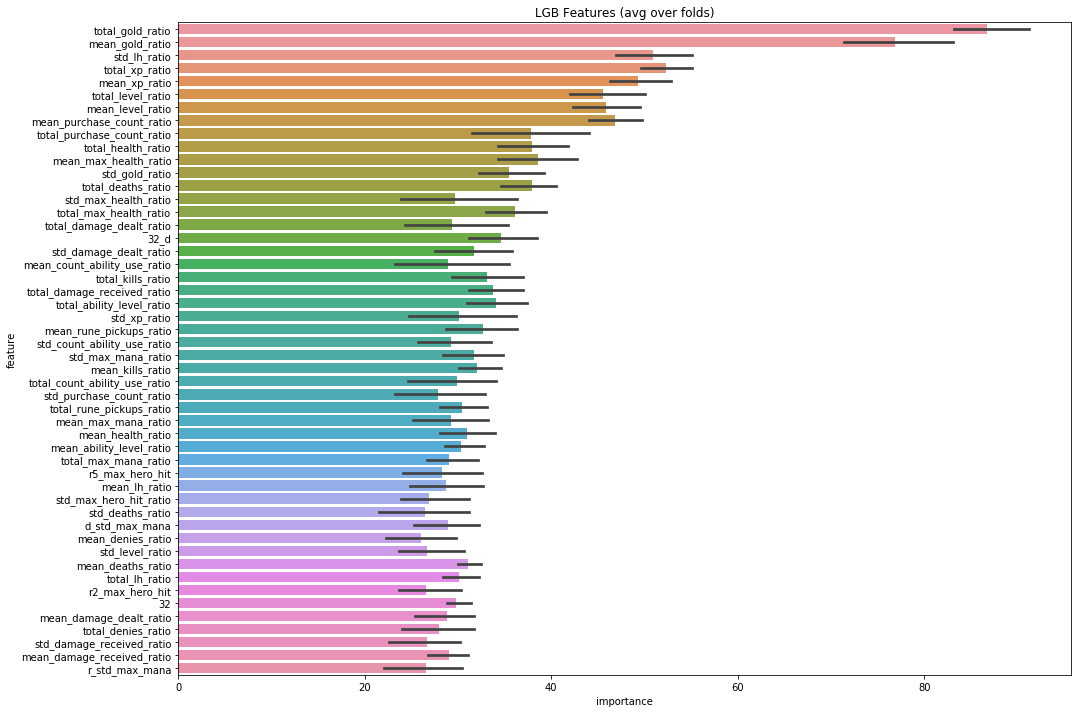

In [104]:
%%time
X = train_new_scaled.reset_index(drop=True)
#X_test = test_new_scaled.copy().reset_index(drop=True)
X_test = test_new_scaled.reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params2, folds=folds, model_type='lgb', plot_feature_importance=True)

In [109]:
#test_new_scaled.index.name = 'match_id_hash'

## Submission File

In [110]:
df_submission = pd.DataFrame({'radiant_win_prob': prediction_lgb}, 
                                 index=test_new_scaled.index)
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2019-04-19_11-03-22.csv


In [111]:
#0.84750

https://lightgbm.readthedocs.io/en/latest/Python-API.html
https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
https://xgboost.readthedocs.io/en/latest/parameter.html


### Годные кернелы
1. https://www.kaggle.com/grazder/hero-items-guide (пикл - 11, использование айтемов героев)
2. https://www.kaggle.com/clair14/gold-is-the-reason-teams-and-bayes-for-lightgbm (формула разреженных герычев)
3. https://www.kaggle.com/kuzand/dota-2-winner-prediction-multilayer-nn-pytorch (описание признаков)
4. https://www.kaggle.com/looterlex/understanding-features-from-json-and-some-ideas(описание признаков)